1. ensure dependencies

In [1]:
import sys
import os
from pathlib import Path

current_dir=str(Path(os.getcwd()).parent.parent.parent)
print(f"Current dir: {current_dir}")
sys.path.insert(0, current_dir)

Current dir: d:\Programming\Python\comfyui-image-scorer


2. main train

In [2]:


from shared.loaders.training_loader import training_loader


from shared.paths import filtered_data

print("--- Step 1: Loading Data ---")
if not os.path.exists(filtered_data):
    x, y = training_loader.load_training_data()
else:
    x, y = training_loader.load_training_data(load_x=False)


print(f"Loaded Data Shape: {x.shape}")

print("\n--- Step 2: Filtering Unused Features ---")
# Removes features with zero variance or zero importance in a quick probe
x, kept_indices = training_loader.filter_unused_features(x, y,500)
print(f"Filtered Data Shape: {x.shape}")

print("\n--- Step 3: Generating Interaction Features ---")
# Adds top 500 polynomial interactions (feature_A * feature_B)
x, _ = training_loader.add_interaction_features(x, y, target_k=1000)
print(f"Final Data Shape (with Interactions): {x.shape}")
print("Data Preparation Complete.")

--- Step 1: Loading Data ---
Loaded Data Shape: (0,)

--- Step 2: Filtering Unused Features ---
Filtering features... Initial shape: (0,)
Loading filtered data from cache: D:\Programming\Python\comfyui-image-scorer\output\models\filtered_data.npz
Filtered Data Shape: (15907, 3025)

--- Step 3: Generating Interaction Features ---
Loading interaction data from cache: D:\Programming\Python\comfyui-image-scorer\output\models\interaction_data.npz
Final Data Shape (with Interactions): (15907, 4025)
Data Preparation Complete.


Training LightGBM: 100%|██████████| 1541/1541 [00:35<00:00, 43.56it/s]


Saved model and diagnostics to: D:\Programming\Python\comfyui-image-scorer\output\models\model.npz
Training complete. Evaluation metrics:
  r2: 0.3613
  mae: 0.8220
  mse: 1.0268
  rmse: 1.0133
  model_type: LGBMRegressor
  training_time: 35.3752
  n_iter: 1541.0000
  loss_curve: [np.float64(0.9870580225093377), np.float64(0.9775205106128516), np.float64(0.9692759534645751), np.float64(0.9606429395917281), np.float64(0.9531025028855209), np.float64(0.9455200527979226), np.float64(0.9389742549182989), np.float64(0.9319485589386418), np.float64(0.9258916207368518), np.float64(0.9200710926245779), np.float64(0.9144642438186308), np.float64(0.9089392485669782), np.float64(0.9033148002853079), np.float64(0.8980181928616283), np.float64(0.893737460118806), np.float64(0.8890080368422312), np.float64(0.884741537001622), np.float64(0.8803219859914624), np.float64(0.8761228451218698), np.float64(0.8723493009531056), np.float64(0.8685056112069482), np.float64(0.8648877902201467), np.float64(0.861

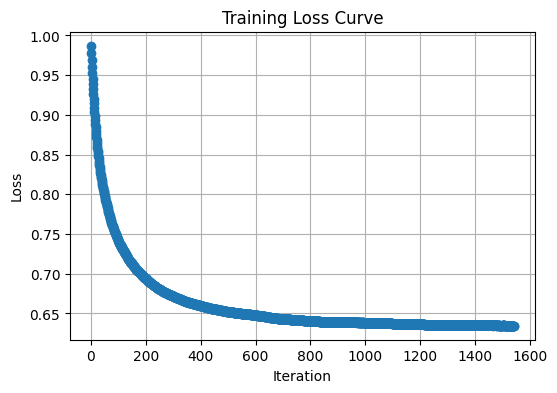

In [3]:
from shared.config import config

import external_modules.step03training.full_data.run as tr
from external_modules.step03training.full_data.analysis import plot_loss_curve

from external_modules.step03training.full_data.model_io import save_model


from shared.paths import training_model

training_cfg = config["training"]

config_selection = "top"

current_config = training_cfg[config_selection]

model, metrics = tr.train_model(
    config_dict=current_config,
    X=x,
    y=y,
    kept_features=kept_indices,
)

score = float(metrics["r2"])
training_time = float(metrics["training_time"])
new_config = {
    **current_config,
    "best_score": score,
    "training_time": training_time,
}
config["training"][config_selection].update(new_config)

save_model(model, training_model, additional_data=metrics)

# Print metrics like run_training did
print("Training complete. Evaluation metrics:")
for k, v in metrics.items():
    try:
        print(f"  {k}: {v:.4f}")
    except Exception:
        print("  {}: {}".format(k, v))

# Friendly post-training suggestion when no diagnostics available
if not metrics.get("has_loss_curve") and not metrics.get("has_n_iter"):
    print(
        "Warning: No training iterations or loss curve were recorded. Consider increasing 'epochs' or using solver='adam' with verbose=True to collect diagnostics."
    )
else:
    plot_loss_curve(training_model, metrics)

In [4]:
import numpy as np
import json

data = np.load(training_model, allow_pickle=True)
print("Saved model diagnostics keys:", list(data.keys()))
if "params" in data:
    raw = data["params"]
    if isinstance(raw, np.ndarray) and raw.shape == ():
        raw = raw.item()
    if isinstance(raw, bytes):
        raw = raw.decode("utf-8")
    if isinstance(raw, str):
        try:
            params = json.loads(raw)
        except Exception:
            try:
                params = eval(raw)
            except Exception:
                params = raw
    else:
        params = raw
    print("  saved params:", params)
# Metrics/loss info may be stored under 'metrics' or top-level keys

metrics_blob = None
if "metrics" in data:
    metrics_blob = data["metrics"]
    try:
        import numpy as _np

        if isinstance(metrics_blob, _np.ndarray) and metrics_blob.shape == ():
            metrics_blob = metrics_blob.item()
    except Exception:
        pass
if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "loss_curve" in metrics_blob
):
    lc = np.asarray(metrics_blob["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])
    else:
        print("  loss_curve present but empty")
elif "loss_curve" in data:
    lc = np.asarray(data["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])

if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "n_iter" in metrics_blob
):
    print("  saved n_iter:", int(metrics_blob["n_iter"]))
elif "n_iter" in data:
    print("  saved n_iter:", int(data["n_iter"]))

Saved model diagnostics keys: ['__model_b64__', 'r2', 'mae', 'mse', 'rmse', 'model_type', 'training_time', 'n_iter', 'loss_curve', 'loss_curve_length', 'has_loss_curve', 'has_n_iter']
  loss_curve (first 10): [0.98705802 0.97752051 0.96927595 0.96064294 0.9531025  0.94552005
 0.93897425 0.93194856 0.92589162 0.92007109]
  saved n_iter: 1541


3. compare with real data

Loading trained model from: D:\Programming\Python\comfyui-image-scorer\output\models\model.npz


d:\Programming\Python\comfyui-image-scorer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Comparison metrics (sample): r2=0.7736, n=500


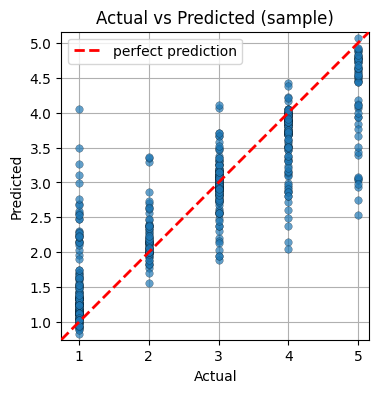

In [5]:
from external_modules.step03training.full_data.analysis import compare_model_vs_data
compare_model_vs_data(training_model, x, y)